In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import scale 
from sklearn import cluster

In [2]:
def open_csv(file, folder, separator):
    """ Open a csv file in a inputs subfolder given a file name, a folder and a separator. """
    if folder != 'inputs':
        path = os.path.join(os.pardir, 'inputs', folder, file)
    else:
        path = os.path.join(os.pardir, 'inputs', file)
    return pd.read_csv(path , sep = separator, engine='python')

In [3]:
def to_date_time(df, column):
    """ Convert a dataframe column to datetime and set it as index. """
    df[[column]] = pd.DataFrame(pd.to_datetime(df[column], format='%d.%m.%Y %H:%M'))
    df.set_index(column, inplace = True)

In [4]:
def time_delta(delta):
    """ Get a timedelta object from a given string with a fomat hrs_min_sec as "00:00:00" hours 
        minutes seconds.
    """
    t = datetime.strptime(delta,"%H:%M:%S")
    return timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)

In [6]:
def weather_data_to_df(file, period_start, period_end, timestep):
    """ Create a dataframe from a csv file of meteorological data for a given period and with a 
        given timestep
    """
    folder = 'external'
    df = open_csv(file, folder, ';')
    to_date_time(df, 'Date')
    
    df = df.truncate(before = period_start, after = period_end)
    
    # Sum over Irradiance values: units of Irradiance are now kWh/m^2/h = kW/m^2
    df = df.resample(time_delta(timestep)).agg({'Irradiance': np.sum, 'Temperature': np.mean})
    df['Irradiance'] /= 1000 
    return df

In [7]:
def reshape_day_hour(hourly_indexed_list, Days, Hours):
    """ Reshape a list with hourly index to a list of list with daily and hour 
    in day index """
    return (np.reshape(hourly_indexed_list, (len(Days), len(Hours))))

In [8]:
# Weather parameters for a summer day at Liebensberg
file = 'meteo_Liebensberg_10min.csv'
start, stop, time_Step, Date_format = '2019-01-01', '2020-01-01', '01:00:00', '%Y-%m-%d'
df_weather = weather_data_to_df(file, start, stop, time_Step)
df_weather.drop(df_weather.tail(1).index,inplace=True)

dt_start = datetime.strptime(start, Date_format)
dt_end = datetime.strptime(stop, '%Y-%m-%d')

# Day index
Days = list(range((dt_end - dt_start).days))

# Hour index
Hours = list(range(0,24))

# External temperature - format Ext_T[Day_index,Hour_index]
Ext_T = reshape_day_hour((df_weather['Temperature'].values), Days, Hours)

# Global irradiance
Irradiance = reshape_day_hour((df_weather['Irradiance'].values), Days, Hours)

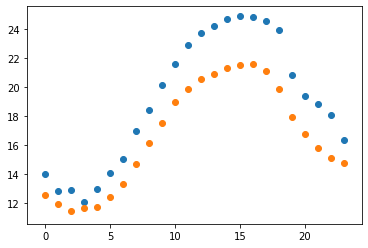

In [9]:
plt.scatter(Hours, Ext_T[151])
plt.scatter(Hours, Ext_T[150])

## create an array X of the shape (nbr_datapoints, nrb_features)

In [10]:
X = np.zeros((len(Days), 48))
for d in Days:
    X[d] = np.concatenate((Ext_T[d], Irradiance[d]), axis=0)

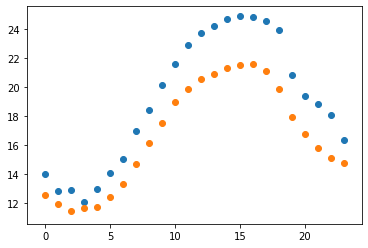

In [11]:
plt.scatter(Hours, X[151][0:24])
plt.scatter(Hours, X[150][0:24])

## Scale the values of the data

In [12]:
scalable = X
Xs = scale(scalable)

## Compute the kmeans clusters

In [13]:
compute_kmeans = cluster.KMeans(n_clusters=8)
compute_kmeans.fit(Xs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
l = compute_kmeans.labels_

In [15]:
colors = {1:'red', 2:'blue', 3:'purple', 4:'orange', 0:'black', 5:'green', 6:'brown', 7:'pink'}

## Identify the elements closest to the centroids

In [16]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(compute_kmeans.cluster_centers_, Xs)
closest

array([241,  50, 189, 268, 261,  32, 309, 154], dtype=int64)

In [50]:
def cluster_by_Kmeans(data, nbr_clusters, algorithm='elkan', tol=1e-8, n_init=10000, n_jobs=8, max_iter=1000000):
    """ Recieve data in the shape of (nbr_data_points, nbr_features)
    and a number of clusters. Use the scale methode form sklearn to
    scale the data. Use the KMeans method to cluster the data.
    Returns an array of cluster labels for each data point and 
    an array of the dtata points closest to the centroids. 
    """
    data_scaled = scale(data)
    compute_kmeans = cluster.KMeans(n_clusters=nbr_clusters)
    compute_kmeans.fit(data_scaled)
    labels, centers = compute_kmeans.labels_, compute_kmeans.cluster_centers_
    
    closest, _ = pairwise_distances_argmin_min(centers, data_scaled)

    return labels.tolist(), closest.tolist()

In [20]:
labels, closest = {}, {}
c = 8
labels[c], closest[c] = cluster_by_Kmeans(X, c)

In [23]:
import json
json_dict = {'labels': labels, 'closest': closest}
with open('clusters.json', 'w') as json_file:
    json.dump(json_dict, json_file)


In [43]:
for n in range(0,30):
    labels, closest = {}, {}
    for c in range(2, 20):
        labels[c], closest[c] = cluster_by_Kmeans(X, c)
    
    json_dict = {'labels': labels, 'closest': closest}
    with open(os.path.join('jsons', f'clusters_5_{n}.json'), 'w') as json_file:
        json.dump(json_dict, json_file)

KeyboardInterrupt: 

In [54]:
for n in range(0,100):
    labels, closest = {}, {}
    for c in [8,9,10,11,12]:
        labels[c], closest[c] = cluster_by_Kmeans(X, c)
    
    json_dict = {'labels': labels, 'closest': closest}
    with open(os.path.join('jsons', f'clusters_6_{n}.json'), 'w') as json_file:
        json.dump(json_dict, json_file)